<a href="https://colab.research.google.com/github/dauparas/tensorflow_examples/blob/master/VAE_with_latent_subspaces_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Variational Autoencoder Model (VAE) with latent subspaces based on:
https://arxiv.org/pdf/1812.06190.pdf

In [1]:
#Step 1: import dependencies
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import regularizers
import time
from __future__ import division

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

%matplotlib inline
plt.style.use('dark_background')

import pandas as pd

Using TensorFlow backend.


In [0]:
t = np.random.uniform(0.0, 1.0, 500)
u = np.random.uniform(0.0, 1.0, 500)
s = np.random.uniform(0.0, 1.0, 500)

In [0]:
X1 = np.cos(t)[:,np.newaxis]
X2 = np.sin(t)[:,np.newaxis]
X3 = (0.5*t)[:,np.newaxis]

X4 = u[:,np.newaxis]
X5 = (u*u)[:,np.newaxis]
X6 = np.sin(0.5*u)[:,np.newaxis]

X7 = (s*s*s)[:,np.newaxis]
X8 = (s+0.2)[:,np.newaxis]
X9 = 3.2*np.cos(0.5*s)[:,np.newaxis]

In [0]:
X = np.concatenate((X1, X2, X3, X4, X5, X6, X7, X8, X9), axis=-1) #data
U=u[:,np.newaxis] #auxiliary data

In [0]:
#Reconstruction loss
def x_given_w_z(w, z, output_size, training_phase, reg):
  with tf.variable_scope('M/x_given_w_z'):
    act = tf.nn.leaky_relu
    
    h = tf.concat((w,z), axis=-1)
    h = tf.layers.dense(h, 8, act, kernel_regularizer=reg)
    h = tf.layers.batch_normalization(h, training=training_phase)
    h = tf.layers.dense(h, 16, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 32, act, kernel_regularizer=reg)
    h = tf.layers.batch_normalization(h, training=training_phase)
    h = tf.layers.dense(h, 64, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 128, act, kernel_regularizer=reg)
    h = tf.layers.batch_normalization(h, training=training_phase)
    h = tf.layers.dense(h, 256, act, kernel_regularizer=reg)
    loc = tf.layers.dense(h, output_size)
    #log_variance = tf.layers.dense(x, latent_size)
    #scale = tf.nn.softplus(log_variance)
    scale = 0.01*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)


#KL term for w
def w_given_x_y(x, y, latent_size, training_phase, reg): #+
  with tf.variable_scope('M/w_given_x_y'):
    act = tf.nn.leaky_relu
    h = tf.concat((x,y), axis=-1)
    
    h = tf.layers.dense(h, 256, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 128, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 64, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 32, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 16, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 8, act, kernel_regularizer=reg)
    
    loc = tf.layers.dense(h,latent_size)
    log_variance = tf.layers.dense(h, latent_size)
    scale = tf.nn.softplus(log_variance)
    #scale = 0.01*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)

def w_given_y(y, y_size, training_phase, reg):
  with tf.variable_scope('M/w_given_y'):
    act = tf.nn.leaky_relu
    h = y
    
    h = tf.layers.dense(h, 256, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 128, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 64, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 32, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 16, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 8, act, kernel_regularizer=reg)
    
    loc = tf.layers.dense(h, y_size)
    log_variance = tf.layers.dense(h, y_size)
    scale = tf.nn.softplus(log_variance)
    return tfd.MultivariateNormalDiag(loc, scale)


#KL term for z
def z_given_x(x, latent_size, training_phase, reg): #+
  with tf.variable_scope('M/z_given_x'):
    act = tf.nn.leaky_relu
    h = x
    
    h = tf.layers.dense(h, 256, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 128, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 64, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 32, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 16, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 8, act, kernel_regularizer=reg)
    
    loc = tf.layers.dense(h,latent_size)
    log_variance = tf.layers.dense(h, latent_size)
    scale = tf.nn.softplus(log_variance)
#     scale = 0.01*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)

def z_given(latent_size):
  with tf.variable_scope('M/z_given'):
    loc = tf.zeros(latent_size)
    scale = 0.1*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)


#For the Mutual information term
def y_given_z(z, y_size, training_phase, reg, reuse=None):
  with tf.variable_scope('N', reuse=reuse):
    act = tf.nn.leaky_relu
    h = z
    
    h = tf.layers.dense(h, 8, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 16, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 32, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 64, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 128, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 256, act, kernel_regularizer=reg)
    
    
    loc = tf.layers.dense(h, y_size)
    log_variance = tf.layers.dense(h, y_size)
    scale = tf.nn.softplus(log_variance)
    #scale = 0.01*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)

In [0]:
#Connect encoder and decoder and define the loss function
tf.reset_default_graph()

x_in = tf.placeholder(tf.float32, shape=[None, X.shape[1]], name='x_in')
x_out = tf.placeholder(tf.float32, shape=[None, X.shape[1]], name='x_out')
u_in = tf.placeholder(tf.float32, shape=[None, 1], name='u_in')
training_phase = tf.placeholder(tf.bool, None, name='training_phase')
reg = regularizers.l1_l2(l1=0.0, l2=0.000000001)

beta = np.array([20.0, 0.1, 0.01, 10.0, 1.0])
#beta= np.array([100000.0, 1.0, 0.02, 10.0, 1.0])

z_latent_size = 2
w_latent_size = 2

M_learning_rate = 5e-4
N_learning_rate = 5e-4

#KL_w
wIy = w_given_y(u_in, w_latent_size, training_phase, reg)
wIxy = w_given_x_y(x_in, u_in, w_latent_size, training_phase, reg)
wIxy_sample = wIxy.sample()
wIxy_mean = wIxy.mean()
kl_w = tf.reduce_mean(wIxy.log_prob(wIxy_sample)- wIy.log_prob(wIxy_sample))
#kl_w = tf.reduce_mean(tfd.kl_divergence(wIxy, wIy)) #analytical

#KL_z
zI = z_given(z_latent_size)
zIx = z_given_x(x_in, z_latent_size, training_phase, reg)
zIx_sample = zIx.sample()
zIx_mean = zIx.mean()
kl_z = tf.reduce_mean(zIx.log_prob(zIx_sample)- zI.log_prob(zIx_sample))
#kl_z = tf.reduce_mean(tfd.kl_divergence(zIx, zI)) #analytical

#Reconstruction
xIwz = x_given_w_z(wIxy_sample, zIx_sample, X.shape[1], training_phase, reg)
rec_out = xIwz.mean()
rec_loss = tf.losses.mean_squared_error(x_out, rec_out)

M1 = beta[0]*rec_loss + beta[1]*kl_w + beta[2]*kl_z

yIz = y_given_z(zIx_sample, U.shape[1], training_phase, reg, reuse=False)
ent2 = -tf.reduce_mean(yIz.entropy())
M2 = beta[3]*ent2

M_reg = tf.losses.get_regularization_loss(scope='M/')

M_cost = M1 + M2 + M_reg

M_optimizer = tf.train.AdamOptimizer(M_learning_rate)

M_train_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='M/')
M_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='M/')

with tf.control_dependencies(M_update_ops):
  M_train = M_optimizer.minimize(M_cost, var_list=M_train_vars,
                                       name='train_M')

  
yIz_N = y_given_z(zIx_sample, U.shape[1], training_phase, reg, reuse=True)
logN = tf.reduce_mean(-yIz_N.log_prob(u_in))
N = beta[4]*logN

N_reg = tf.losses.get_regularization_loss(scope='N')

N_cost = N + N_reg



N_optimizer = tf.train.AdamOptimizer(N_learning_rate)

N_train_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='N')
N_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='N')

with tf.control_dependencies(N_update_ops):
  N_train = N_optimizer.minimize(N_cost, var_list=N_train_vars,
                                       name='train_N')

# Saver to save session for reuse
saver = tf.train.Saver()

In [0]:
#Helper function
def batch_generator(features, x, u, batch_size):
  """Function to create python generator to shuffle and split features into batches along the first dimension."""
  idx = np.arange(features.shape[0])
  np.random.shuffle(idx)
  for start_idx in range(0, features.shape[0], batch_size):
    end_idx = min(start_idx + batch_size, features.shape[0])
    part = idx[start_idx:end_idx]
    yield features[part,:], x[part,:] , u[part, :]

In [28]:
X.shape[0]

500

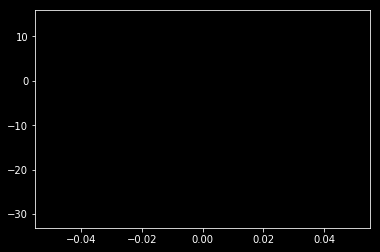

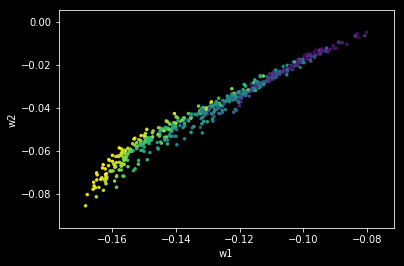

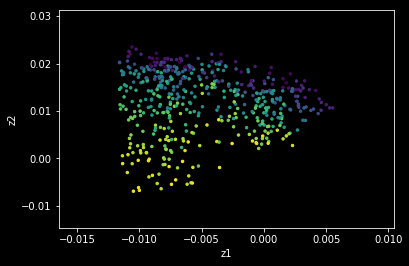

epoch: 1, M_loss: 17.1, M1_loss: 24.8, M2_loss: -7.7, N_loss: 0.20
epoch: 1, rec_loss: 1.22344, kl_w: 0.01, kl_z: 34.08


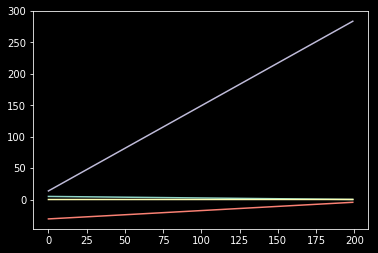

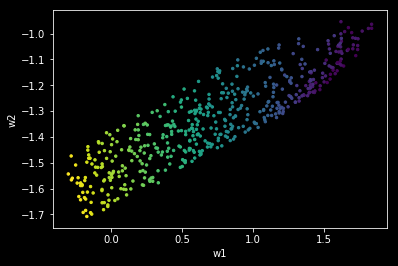

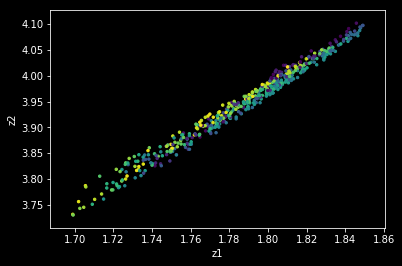

epoch: 200, M_loss: 6.2, M1_loss: 7.3, M2_loss: -1.1, N_loss: 0.03
epoch: 200, rec_loss: 0.01030, kl_w: 0.18, kl_z: 708.73


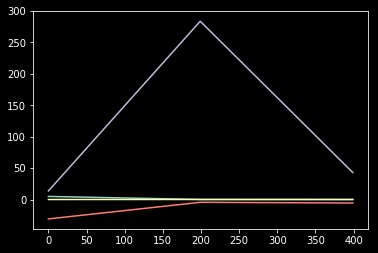

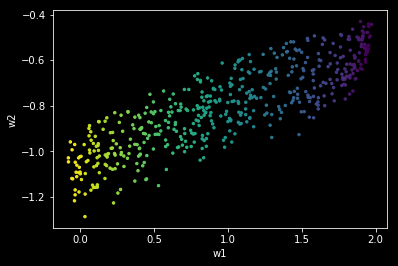

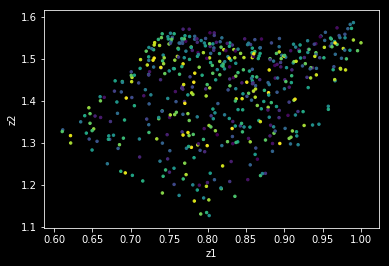

epoch: 400, M_loss: -0.2, M1_loss: 1.2, M2_loss: -1.4, N_loss: 0.04
epoch: 400, rec_loss: 0.00558, kl_w: 0.02, kl_z: 107.26


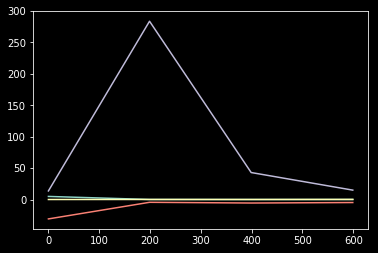

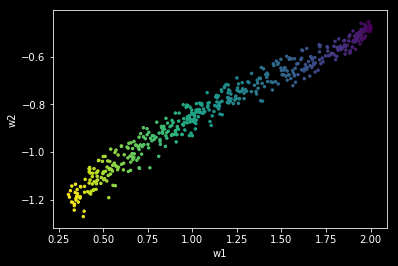

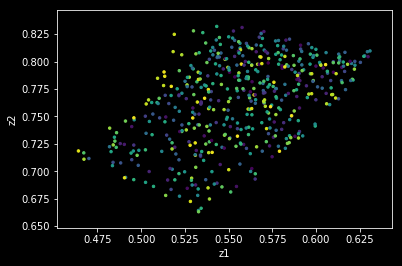

epoch: 600, M_loss: -0.7, M1_loss: 0.5, M2_loss: -1.2, N_loss: 0.04
epoch: 600, rec_loss: 0.00355, kl_w: 0.37, kl_z: 37.30


KeyboardInterrupt: ignored

In [29]:
n_epochs = 15000
batch_size = 128
start = time.time()
rec_out_plt = []
kl_w_plt= []
kl_z_plt = []
epoch_plt = []
M2_plt = []
N_loss_plt = []
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  
  
  for i in range(n_epochs):
    gen = batch_generator(X, X, U[:,0][:,np.newaxis], batch_size) #create batch generator
    M_loss = 0
    N_loss = 0
    rec_loss_ = 0
    kl_w_ = 0
    kl_z_ = 0
    M1_ = 0
    M2_ = 0
    ent2_ = 0
    logN_ = 0
    
    for j in range(np.int(X.shape[0]/batch_size)):
      x_in_batch, x_out_batch, u_batch = gen.__next__()
      
      
      _, M_loss_, rec_loss__, kl_w__, kl_z__, M1__, ent2__, M2__= sess.run([M_train, M_cost, rec_loss, kl_w, kl_z, M1, ent2, M2], feed_dict={x_in: x_in_batch, x_out: x_out_batch, u_in: u_batch, training_phase:True})
      M_loss += M_loss_
      rec_loss_ += rec_loss__
      kl_w_ += kl_w__
      kl_z_ += kl_z__
      M1_ += M1__
      M2_ += M2__
      
      _, N_loss_, logN__= sess.run([N_train, N_cost, logN], feed_dict={x_in: x_in_batch, x_out: x_out_batch, u_in: u_batch, training_phase:True})
      N_loss += N_loss_
      logN_ += logN__
      
      
    if (i+1)% 200 == 0 or i == 0:
      wIxy_mean_, zIx_mean_, rec_out_= sess.run([wIxy_mean, zIx_mean, rec_out], feed_dict ={x_in:X, x_out:X, u_in:U[:,0][:,np.newaxis], training_phase:False})
      rec_out_plt.append(rec_loss_)
      kl_w_plt.append(kl_w_/10.0)
      kl_z_plt.append(kl_z_/10.0)
      M2_plt.append(M2_/1.0)
      N_loss_plt.append(N_loss)
      epoch_plt.append(i)
      
      plt.figure(1) 
      plt.plot(epoch_plt[-10:], rec_out_plt[-10:])
      plt.plot(epoch_plt[-10:], kl_w_plt[-10:])
      plt.plot(epoch_plt[-10:], kl_z_plt[-10:])
      plt.plot(epoch_plt[-10:], M2_plt[-10:])
      
      plt.figure(2)
      plt.scatter(wIxy_mean_[:,0],wIxy_mean_[:,1], c=U[:,0], s=6.0, cmap='viridis');
      plt.xlabel('w1');
      plt.ylabel('w2');
      
      plt.figure(3)
      plt.scatter(zIx_mean_[:,0],zIx_mean_[:,1], c=U[:,0], s=6.0, cmap='viridis');
      plt.xlabel('z1');
      plt.ylabel('z2');
      plt.show()
      
      end = time.time()
      print('epoch: {0}, M_loss: {1:.1f}, M1_loss: {2:.1f}, M2_loss: {3:.1f}, N_loss: {4:.2f}'.format((i+1), M_loss/(1+np.int(X.shape[0]/batch_size)), M1_/(1+np.int(X.shape[0]/batch_size)), M2_/(1+np.int(X.shape[0]/batch_size)), N_loss_/(1+np.int(X.shape[0]/batch_size))))
      print('epoch: {0}, rec_loss: {1:.5f}, kl_w: {2:.2f}, kl_z: {3:.2f}'.format((i+1), rec_loss_/(1+np.int(X.shape[0]/batch_size)), kl_w_/(1+np.int(X.shape[0]/batch_size)), kl_z_/(1+np.int(X.shape[0]/batch_size))))
      start = time.time()